## Data Visualization with OpenAI Assistants API

In this example, we upload a simple CSV file containing the earnings and spending of a person by month in a year. We ask the AI assistant to draw some insights from this data and provide us with 3 graphs that helps in visualizing the data and insights. 

### Environment Setup

In [ ]:
!pip install openai
!pip install python-dotenv
!pip install pillow
!pip install termcolor

In [1]:
from openai import OpenAI
import os
from dotenv import load_dotenv
import json
import time
from PIL import Image

### OpenAI API Setup

The OpenAI API key is placed in a `.env` file. If you don't have one, create a file named `.env` and update with the following. Replace `sk_this_is_a_sample_key` with your OpenAI API key.

`OPENAI_API_KEY=sk_this_is_a_sample_key`

In [2]:
_ = load_dotenv()

client = OpenAI(
    api_key = os.environ['OPENAI_API_KEY']
)

### Create the assistant

In [3]:
assistant = client.beta.assistants.create(
  name="Data visualizer",
  description='''You are great at creating beautiful data visualizations. 
  Your task is to analyze data present in .csv files, understand trends, 
  come up with data visualizations relevant to those trends and provide a brief summary of the trends observed.''',
  model="gpt-4-1106-preview",
  tools=[{"type": "code_interpreter"}],
)

### Upload a file

The CSV file can be downloaded from here - [savings-2023.csv](). It needs to be placed in the same directory where this Jupyter Notebook is placed. 

In [4]:
file = client.files.create(
  file=open("./docs/savings-2023.csv", "rb"),
  purpose='assistants'
)

### Create a new thread

In [5]:
# Pass in the uploaded file along with the user message
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "file_ids": [file.id],
      "content": '''Here is a CSV file containing a person's monthly earnings 
      and savings in dollars for the year 2023. Create 3 data visualizations 
      based on the trends in this csv file.'''
    }
  ]
)

### Run the assistant

In [6]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

### Check the status of the run

We need to poll a few times to retrieve the latest run status until it returns `completed`. Run this cell in a few seconds interval until it prints `completed`. There is a little helper function at the end of this notebook which would automate that polling process. 

In [9]:
run_retrieved = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
)

run_retrieved.status

'completed'

### Display the response

In [10]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

In [11]:
message_json = json.loads(messages.model_dump_json())
print(json.dumps(message_json, indent=2))

{
  "data": [
    {
      "id": "msg_7yOzaSWlThxFMkLIswtVZFes",
      "assistant_id": "asst_efYolN9g08JvT20VvvaqrJyR",
      "content": [
        {
          "image_file": {
            "file_id": "file-xV2VnpMnIdXjvtAX7cJeuOoa"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Three visualizations from the data provided are displayed above:\n\n1. A line plot showing the trend of earnings over the year 2023, with markers indicating individual months.\n2. A line plot illustrating the trend of savings over the year 2023, again with markers for each month.\n3. A bar plot comparing earnings to savings for each month, providing a clear contrast between the two values.\n\nThese visualizations offer insights into the person's financial trends throughout the year and allow for comparisons between earnings and savings on a month-by-month basis."
          },
          "type": "text"
        }
      ],
      

In [12]:
from termcolor import colored

def pretty_print_conversation(messages):
    role_to_color = {
        "system": "red",
        "user": "green",
        "assistant": "blue",
        "function": "magenta",
        "other": "yellow"
    }
    for data in messages.data:
        if data.role == "assistant":
            printAssistantMessage(data, role_to_color)
        elif data.role == "user":
            printUserMessage(data, role_to_color)
        else:
            printOtherMessage(data, role_to_color)

def printAssistantMessage(data, role_to_color):
    for content in data.content:
        if content.type == "image_file":
            print(colored(f"assistant: Image File Id = {content.image_file.file_id}\n", role_to_color[data.role]))
        elif content.type == "text":
            print(colored(f"assistant: {content.text.value}\n", role_to_color[data.role]))
    print(colored("**********\n", "cyan"))

def printUserMessage(data, role_to_color):
    for content in data.content:
        print(colored(f"user: {content.text.value}\n", role_to_color[data.role]))

def printOtherMessage(data, role_to_color):
    for content in data.content:
        print(colored(f"{data.role}: {content.text.value}\n", role_to_color[data.role]))

In [13]:
pretty_print_conversation(messages)

assistant: Image File Id = file-xV2VnpMnIdXjvtAX7cJeuOoa

assistant: Three visualizations from the data provided are displayed above:

1. A line plot showing the trend of earnings over the year 2023, with markers indicating individual months.
2. A line plot illustrating the trend of savings over the year 2023, again with markers for each month.
3. A bar plot comparing earnings to savings for each month, providing a clear contrast between the two values.

These visualizations offer insights into the person's financial trends throughout the year and allow for comparisons between earnings and savings on a month-by-month basis.

**********

assistant: The 'Earnings' and 'Savings' columns have been successfully converted to integer values. Now, let's proceed with creating the visualizations:

1. A line plot showing the trend of earnings over the year 2023.
2. A line plot showing the trend of savings over the year 2023.
3. A bar plot comparing earnings to savings for each month.

**********


### Retrieve file content

https://platform.openai.com/docs/api-reference/files/retrieve-contents

### Use Pillow library to load the image and display it

In [14]:
from PIL import Image

In [15]:
def get_images(messages):
    image_files = []
    for data in messages.data:
        if data.role == "assistant":
            for content in data.content:
                if content.type == "image_file":
                    image = client.files.content(content.image_file.file_id)
                    image_files.append(image)
        else: 
            break
    return image_files

def get_new_dimensions(original_dimension, custom_width, custom_height):
    original_width, original_height = original_dimension
    aspect_ratio = original_width / original_height

    # Calculate the new dimensions while maintaining the aspect ratio
    if custom_width / aspect_ratio <= custom_height:
        new_width = custom_width
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = custom_height
        new_width = int(new_height * aspect_ratio)

    return (new_width, new_height)

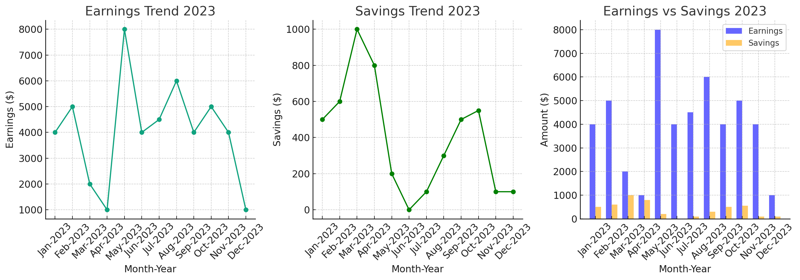

In [16]:
# Get the images from assistant response
image_files = get_images(messages) 
for image_file in image_files:
    image = Image.open(image_file)
    new_width, new_height = get_new_dimensions(image.size, 800, 600)
    resized_image = image.resize((new_width, new_height))
    resized_image.show()

### Use a polling function and callback

The polling function - `get_assistant_response()` - will loop through a specified number of times at regular intervals to retrieve the run status. Once the run status turns to `completed`, it will invoke a callback function - `handle_response()` - to display the conversation and the images that the AI assistant generated. 

In [17]:
# The function to poll the run status in a regular interval for a specified amount of times
def get_assistant_response(thread_id, run_id, callback, interval=10, max_attempts=60):
    attempts = 0
    while attempts < max_attempts:
        try:
            updated_run = client.beta.threads.runs.retrieve(
              thread_id=thread_id,
              run_id=run_id
            )
            status = updated_run.status
            # Check if the status indicates completion
            if status == "completed":
                callback(status, thread_id)
                break
            else:
                callback(f"Run status: {status}")
                
            time.sleep(interval)
            attempts += 1   
        except Exception as e:
            callback(f"Error: {str(e)}")
            time.sleep(interval)
            attempts += 1
    else:
        # If max_attempts reached without completion, call the callback with a timeout message
        callback("Timeout: Assistant didn't respond in time. Please try again.")

# Callback function to handle the run status
def handle_response(status, thread_id=None):
    if status == "completed":
        print("Run completed successfully.")
        display_messages(thread_id)
    else:
        print(status)

# Function to display the assistant's response
def display_messages(thread_id):
    messages = client.beta.threads.messages.list(
      thread_id=thread_id
    )

    # Print the conversation
    pretty_print_conversation(messages)

    # Display the visualizations created by the assistant
    image_files = get_images(messages) 
    for image_file in image_files:
        image = Image.open(image_file)
        new_width, new_height = get_new_dimensions(image.size, 800, 600)
        resized_image = image.resize((new_width, new_height))
        resized_image.show()

Let's create a new thread and a new run to invoke the assistant again using the above utility functions and display the reponse

In [18]:
thread_1 = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "file_ids": [file.id],
      "content": '''Here is a CSV file containing a person's monthly earnings and savings in dollars for the year 2023. 
      Create 3 data visualizations based on the trends in this csv file.'''
    }
  ]
)

In [19]:
run_1 = client.beta.threads.runs.create(
    thread_id=thread_1.id,
    assistant_id=assistant.id
)

Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run completed successfully.
assistant: Image File Id = file-SzptZ47OyPeuYq3SndZz2T6G

assistant: Here are the three visualizations based on the trends in the CSV data:

1. The line plot shows the trend of monthly earnings and savings over the year 2023. Each point on the lines represents the amount of earnings or savings for a particular month.

2. The bar chart compares the monthly earnings against savings side-by-side, allowing us to see the relative amounts for each month.

3. The pie chart illustrates the proportion of total savings compared to the total amount spent (earnings minus savings) for the year 2023.

These visualizations should give a comprehensive view of the person's financial trends throughout the year. If you have any further analysis or different types of visualizations in mind, feel free to let me kn

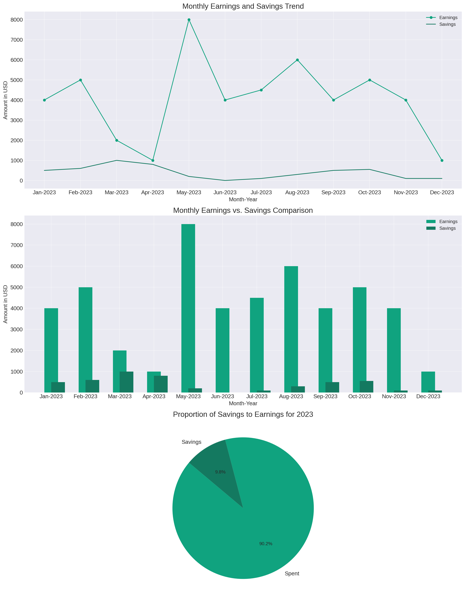

In [20]:
get_assistant_response(thread_1.id, run_1.id, handle_response)